In [1]:
import numpy as np
import os
from astropy.io import fits
import astropy.units as u
import skimage.transform

import matplotlib
import matplotlib.pyplot as plt

plt.style.use('default')
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['axes.linewidth'] = 1.
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 16
#plt.style.use('dark_background')
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

cmap='inferno'
matplotlib.rcParams['image.cmap'] = cmap

In [2]:
N_epoch = 4
deltaT_series = np.array([0, 0.15, 1.0, 2.0]) * u.year

In [3]:
coadd_data_dir = os.path.relpath("../../Data/official2019/HLC/HLC DATA/")
analysis_results_dir = os.path.relpath("./results/")

plot_results_dir = os.path.join(analysis_results_dir, "plots")
if not os.path.exists(plot_results_dir):
    os.mkdir(plot_results_dir)

In [4]:
os.listdir(coadd_data_dir)

['HLC_refstar_coadd_epoch04.fits',
 'HLC_refstar_coadd_epoch02.fits',
 'HLC_refstar_stack_epoch01.fits',
 'HLC_scistar_coadd_epoch01.fits',
 'HLC_refstar_coadd_epoch03.fits',
 'HLC_scistar_coadd_epoch02.fits',
 'HLC_refstar_stack_epoch03.fits',
 'HLC_refstar_stack_epoch02.fits',
 'HLC_scistar_coadd_epoch03.fits',
 'HLC_refstar_coadd_epoch01.fits',
 'HLC_scistar_coadd_epoch04.fits',
 'HLC_refstar_stack_epoch04.fits']

In [5]:
sci_coadd_fname_list = [
        'HLC_scistar_coadd_epoch01.fits',
        'HLC_scistar_coadd_epoch02.fits',
        'HLC_scistar_coadd_epoch03.fits',
        'HLC_scistar_coadd_epoch04.fits']

ref_coadd_fname_list = [
        'HLC_refstar_coadd_epoch01.fits',
        'HLC_refstar_coadd_epoch02.fits',
        'HLC_refstar_coadd_epoch03.fits',
        'HLC_refstar_coadd_epoch04.fits']

In [6]:
sci_coadd_fname = os.path.join(coadd_data_dir, sci_coadd_fname_list[0])
fits.info(sci_coadd_fname)

Filename: ../../Data/official2019/HLC/HLC DATA/HLC_scistar_coadd_epoch01.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   (45, 45, 2)   float64   
  1  ROLLS         1 ImageHDU         7   (2,)   float64   


In [7]:
sci_hdr = fits.getheader(sci_coadd_fname)
sci_hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   45                                                  
NAXIS2  =                   45                                                  
NAXIS3  =                    2                                                  
EXTEND  =                    T                                                  
UNITS   = 'photoelectrons'                                                      
INTTIME =              66000.0 / seconds per roll per epoch                     
PIX_AS  =            0.0210804 / arcsec                                         
PIX_LD  =   0.4200002390847835 / lam/D                                          
LAMBDA  =                575.0 / nm                                             
MINLAM  =               546.

In [8]:
imwidth = sci_hdr['NAXIS1']
pixscale_LoD = sci_hdr['PIX_LD']
pixscale_as = sci_hdr['PIX_AS']
rolls = fits.getdata(sci_coadd_fname, ext=1)
print(imwidth, pixscale_LoD, rolls)

45 0.4200002390847835 [ 0. 26.]


In [9]:
ref_det_coadd = np.zeros((N_epoch, imwidth, imwidth))
rollminus_det_coadd = np.zeros((N_epoch, imwidth, imwidth))
rollplus_det_coadd = np.zeros((N_epoch, imwidth, imwidth))

In [10]:
for tt in range(N_epoch):
    sci_coadd_fname = os.path.join(coadd_data_dir, sci_coadd_fname_list[tt])
    ref_coadd_fname = os.path.join(coadd_data_dir, ref_coadd_fname_list[tt])

    rollminus_det_coadd[tt] = fits.getdata(sci_coadd_fname)[0, :, :]
    rollplus_det_coadd[tt] = fits.getdata(sci_coadd_fname)[1, :, :]
    ref_det_coadd[tt] = fits.getdata(ref_coadd_fname)

### Mask and vectorize the images

In [11]:
def vectorize_image_series(image_series, data_mask_nan):
    data_ind = np.where( ~np.isnan(data_mask_nan) )
    nan_ind = np.where( np.isnan(data_mask_nan) )
    N_pix = len(data_ind[0])
    N_mask = len(nan_ind[0])
    vec_series = image_series[:,data_ind[0],data_ind[1]]
    
    return vec_series, data_ind, nan_ind, N_pix, N_mask

def get_correlation_matrix(data_vec_series):
    Nt = data_vec_series.shape[0]
    corr_matx = np.zeros((Nt, Nt))
    for ti in range(Nt):
        for tj in range(ti+1):
            corrcoef_matx = np.corrcoef(data_vec_series[ti], data_vec_series[tj])
            corr_matx[ti, tj] = corrcoef_matx[0][1]
            corr_matx[tj, ti] = corr_matx[ti, tj]

    return corr_matx

In [12]:
import scipy.stats

x_try = np.arange(imwidth)
y_try = np.arange(imwidth)

x_try, y_try = np.meshgrid(x_try, y_try)
xs_p = np.arange(imwidth) - imwidth // 2
ys_p = xs_p.copy()
xxs_p, yys_p = np.meshgrid(xs_p, ys_p)
rrs_p = np.sqrt(xxs_p**2 + yys_p**2)
data_select = np.logical_or(rrs_p >= 8.6 / pixscale_LoD, rrs_p <= 2. / pixscale_LoD)
data_mask = np.where(np.equal(~data_select, 1), 1, np.nan)

#ref_series = np.array(ref_det_coadd)[:,cw:-cw,cw:-cw]
#target_rollminus_series = np.array(rollminus_det_coadd)[:,cw:-cw,cw:-cw]
#target_rollplus_series = np.array(rollplus_det_coadd)[:,cw:-cw,cw:-cw]

ref_series = ref_det_coadd
target_rollminus_series = rollminus_det_coadd
target_rollplus_series = rollplus_det_coadd

ref_vec_series, data_ind, nan_ind, Npix, Nexc = vectorize_image_series(ref_series, data_mask)
target_vec_minus_series, data_ind, nan_ind, Npix, Nexc = vectorize_image_series(target_rollminus_series, data_mask)
target_vec_plus_series, data_ind, nan_ind, Npix, Nexc = vectorize_image_series(target_rollplus_series, data_mask)

Nref = ref_series.shape[0]

In [13]:
rdi_cube = np.zeros((len(rolls), N_epoch, imwidth, imwidth))
rdi_rollcomb_cube = np.zeros((N_epoch, imwidth, imwidth))

for epind in range(N_epoch):
    target_vec_minus = target_vec_minus_series[epind].reshape((1, Npix))
    target_vec_plus = target_vec_plus_series[epind].reshape((1, Npix))
    
    data_matx = np.concatenate([ref_vec_series, target_vec_minus, target_vec_plus], axis=0)

    raw_corr_matx = get_correlation_matrix(data_matx)

    peak_corr = np.max( raw_corr_matx[Nref:, :Nref], axis=1 )
    peak_corr_ref_ind = np.argmax( raw_corr_matx[Nref:, :Nref], axis=1 )
    print('peak corr ref ind for roll -13 = {:d}'.format(peak_corr_ref_ind[0]))
    print('peak corr ref ind for roll +13 = {:d}'.format(peak_corr_ref_ind[1]))
    
    b, a, _, _, _ = scipy.stats.linregress(ref_vec_series[ peak_corr_ref_ind[0] ], target_vec_minus)
    rdi_cube[0, epind, :, :] = target_rollminus_series[epind] - (a + b*ref_series[peak_corr_ref_ind[0]])

    b, a, _, _, _ = scipy.stats.linregress(ref_vec_series[ peak_corr_ref_ind[1] ], target_vec_plus)
    rdi_cube[1, epind, :, :] = target_rollplus_series[epind] - (a + b*ref_series[peak_corr_ref_ind[1]])
    
    derot_rollplus_image = skimage.transform.rotate(rdi_cube[1, epind], angle = rolls[1],
                                                    order = 3, resize = False,
                                                    center=(imwidth // 2, imwidth // 2), cval=0)
    rdi_rollcomb_cube[epind, :, :] = rdi_cube[0, epind] + derot_rollplus_image

peak corr ref ind for roll -13 = 0
peak corr ref ind for roll +13 = 0
peak corr ref ind for roll -13 = 1
peak corr ref ind for roll +13 = 2
peak corr ref ind for roll -13 = 3
peak corr ref ind for roll +13 = 3
peak corr ref ind for roll -13 = 3
peak corr ref ind for roll +13 = 3


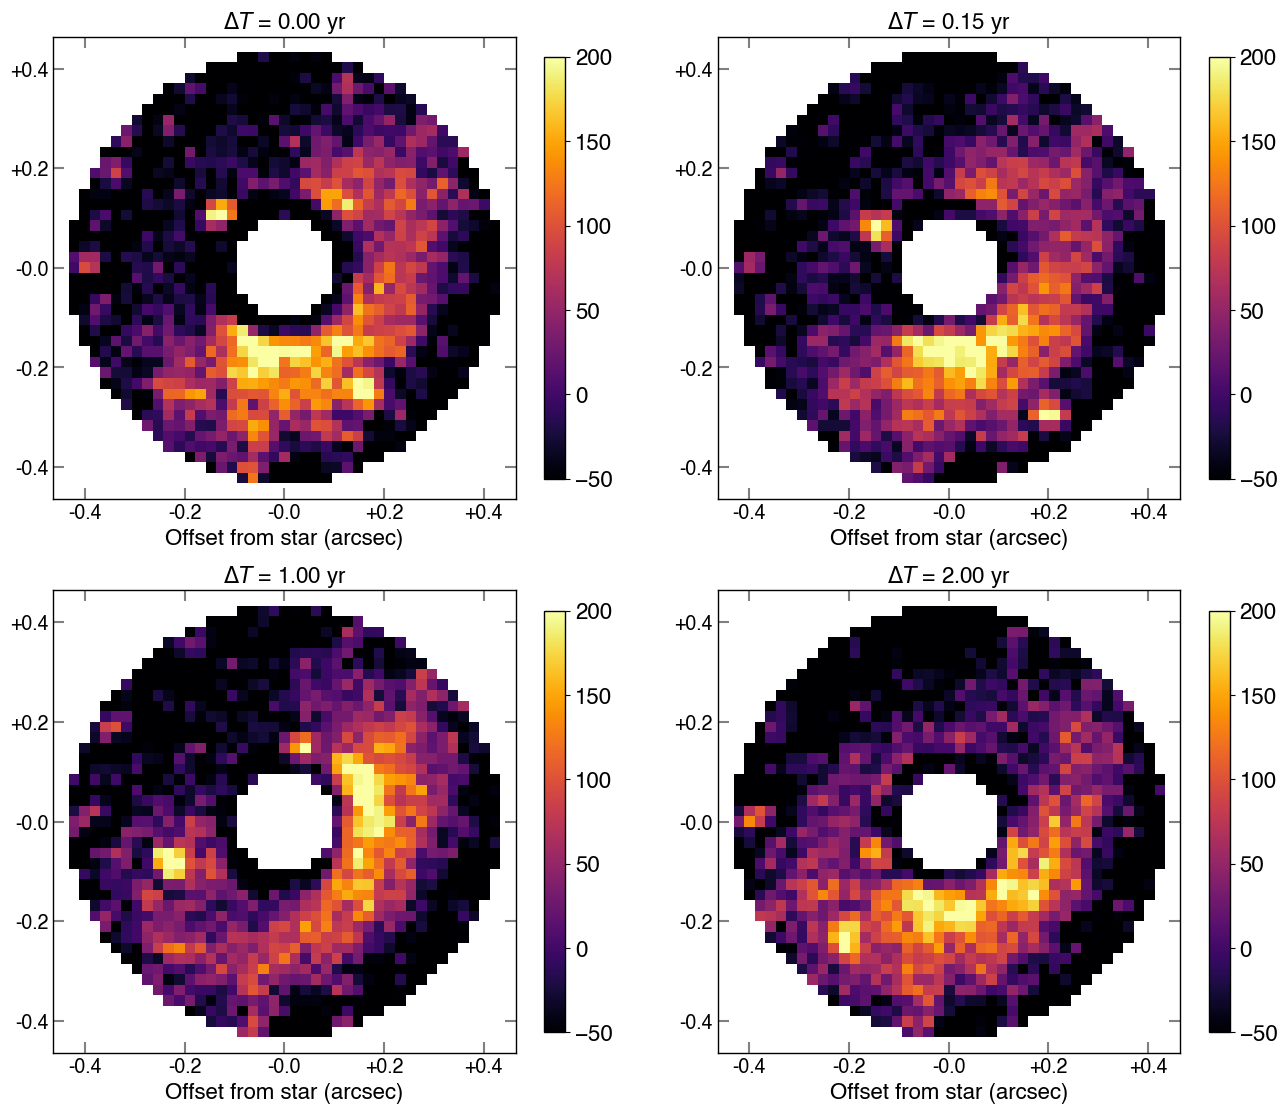

In [14]:
#plt.figure(figsize=(16,10))
#plt.subplots_adjust(top=0.95, left=0.04, right=0.98, bottom=0.03, hspace=0.02, wspace=0.15)

#plt.figure(figsize=(12,11))
#plt.subplots_adjust(top=0.92, left=0.05, right=0.98, bottom=0.07, hspace=0.25, wspace=0.15)

plt.figure(figsize=(13.5, 11.5))
plt.subplots_adjust(top=0.98, left=0.05, right=0.97, bottom=0.04, hspace=0.05, wspace=0.15)

#plt.suptitle('RDI processed co-adds at sample observation epochs\nTotal integration time {:.1f} hrs per epoch'.format(
#              tot_inttime_rollminus[0]*2/3600 ), size=20)

#plt.suptitle('RDI processed co-adds at sample observation epochs', size=20)

epoch_plot_inds = range(N_epoch)

vmax = 200
vmin = -50

plt.subplot(221)

plt.imshow(rdi_rollcomb_cube[epoch_plot_inds[0]] * data_mask,
           origin='lower', vmin=vmin, vmax=vmax, interpolation='none')

xtick_locs = np.arange(-1, 1, 0.2) / pixscale_as + imwidth // 2
xtick_labels = ['{:+.1f}'.format(loc) for loc in np.arange(-1, 1, 0.2)]
plt.xticks(xtick_locs, xtick_labels, size=14)
plt.xlim([0,imwidth-1])
plt.yticks(xtick_locs, xtick_labels, size=14)
plt.ylim([0,imwidth-1])
plt.tick_params('both', length=8, width=1.5, which='major', top=True, right=True,
                direction='in', color='gray')
plt.xlabel('Offset from star (arcsec)')
plt.colorbar(shrink=0.8)
plt.title('$\Delta T$ = {:.2f}'.format(deltaT_series[0]), size=16)

plt.subplot(222)

plt.imshow(rdi_rollcomb_cube[epoch_plot_inds[1]] * data_mask,
           origin='lower', vmin=vmin, vmax=vmax, interpolation='none')
plt.xticks(xtick_locs, xtick_labels, size=14)
plt.xlim([0,imwidth-1])
plt.yticks(xtick_locs, xtick_labels, size=14)
plt.ylim([0,imwidth-1])
plt.tick_params('both', length=8, width=1.5, which='major', top=True, right=True,
                direction='in', color='gray')
plt.xlabel('Offset from star (arcsec)')
plt.colorbar(shrink=0.8)
plt.title('$\Delta T$ = {:.2f}'.format(deltaT_series[1]), size=16)

if N_epoch > 2:
    plt.subplot(223)
    plt.imshow(rdi_rollcomb_cube[epoch_plot_inds[2]] * data_mask,
               origin='lower', vmin=vmin, vmax=vmax, interpolation='none')
    plt.xticks(xtick_locs, xtick_labels, size=14)
    plt.xlim([0,imwidth-1])
    plt.yticks(xtick_locs, xtick_labels, size=14)
    plt.ylim([0,imwidth-1])
    plt.tick_params('both', length=8, width=1.5, which='major', top=True, right=True,
                    direction='in', color='gray')
    plt.xlabel('Offset from star (arcsec)')
    plt.colorbar(shrink=0.8)
    plt.title('$\Delta T$ = {:.2f}'.format(deltaT_series[2]), size=16)

    plt.subplot(224)
    plt.imshow(rdi_rollcomb_cube[epoch_plot_inds[3]] * data_mask,
               origin='lower', vmin=vmin, vmax=vmax, interpolation='none')
    plt.xticks(xtick_locs, xtick_labels, size=14)
    plt.xlim([0,imwidth-1])
    plt.yticks(xtick_locs, xtick_labels, size=14)
    plt.ylim([0,imwidth-1])
    plt.tick_params('both', length=8, width=1.5, which='major', top=True, right=True,
                    direction='in', color='gray')
    plt.xlabel('Offset from star (arcsec)')
    plt.colorbar(shrink=0.8)
    plt.title('$\Delta T$ = {:.2f}'.format(deltaT_series[3]), size=16)

sample_rdi_coadds_fname = os.path.join(plot_results_dir, 'HLC_scistar_RDI_rollcomb_seq.png')
plt.savefig(sample_rdi_coadds_fname, dpi=200)

### Write roll-combined RDI sequence to a FITS cube

In [15]:
rdi_rollcomb_cube_fname = os.path.join(analysis_results_dir,
                                       'HLC_scistar_RDI_rollcomb_seq.fits')

rdi_rollcomb_seq_hdu = fits.PrimaryHDU(rdi_rollcomb_cube 
                                       * np.tile(data_mask[np.newaxis, :, :],
                                       (N_epoch, 1, 1)))

rdi_rollcomb_seq_hdu.header = sci_hdr.copy()

rdi_rollcomb_seq_hdu.header['INTTIME'] = (2 * sci_hdr['INTTIME'], 'seconds per epoch')
rdi_rollcomb_seq_hdu.header.remove('EPOCH')

rdi_rollcomb_seq_hdu.writeto(rdi_rollcomb_cube_fname, overwrite=True)